In [1]:
import tensorflow as tf

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Build model with model_architecture.json

In [2]:
import os
import json
import flwr as fl

with open('../Server/model_architecture.json','r') as file:
    json_data = file.read()
model_architecture = json.loads(json_data)
model = tf.keras.models.model_from_json(model_architecture)
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0

## Load the latest weights

In [3]:
import numpy as np

files_list=[]
# check every file under the root directory to have .npy extension
for root, dirs, files in os.walk('../Server/fl_sessions/', topdown = False):
    for file in files:
        if file.endswith(".npy"):
            files_list.append(os.path.join(root,file))
# get the latest file
latest_params_file = max(files_list, key=os.path.getmtime)
# load the weights from the file
latest_params=np.load(latest_params_file,allow_pickle=True)

latest_weights = fl.common.parameters_to_ndarrays(latest_params[0])

model.set_weights(latest_weights)


## Run predict and plot confussion matrix


In [4]:
(_,_),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
y_test = y_test.reshape(-1)
x_test = x_test/255.
predictions = model.predict(x_test)

313/313 [==============================] - 3s 3ms/step


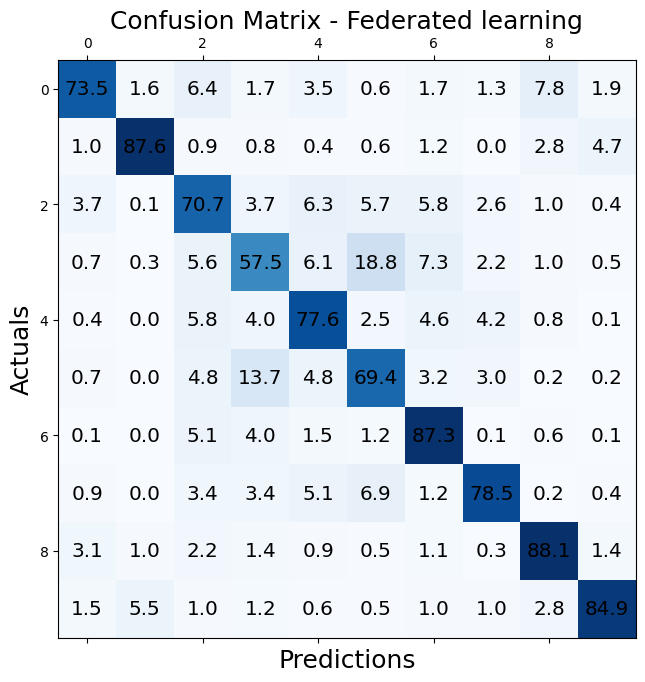

In [5]:
import matplotlib.pyplot as plt
model_preds = predictions.argmax(axis=1)

confusion  = tf.math.confusion_matrix(
    labels=y_test,
    predictions=model_preds,
    num_classes=10    
)
conf_matrix = np.array(confusion)
# print(conf_matrix)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha = 1)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j]/10, va='center', ha='center', size='x-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix - Federated learning', fontsize=18)
plt.show()        
plt.show()

## Plot the loss and accuracy

[0.506250003973643, 0.6166666746139526, 0.6729166706403097, 0.7093749841054281, 0.7354166507720947, 0.743749996026357, 0.7364583412806193, 0.765625, 0.7562499841054281, 0.762500007947286] [1.4572503169377644, 1.1140749057133992, 0.980726420879364, 0.8649920423825582, 0.8237911065419515, 0.7948866287867228, 0.7604745825131735, 0.7572019100189209, 0.7663133144378662, 0.7664728164672852]


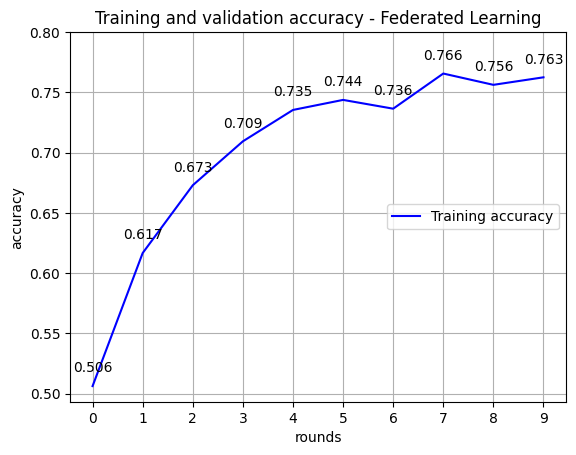

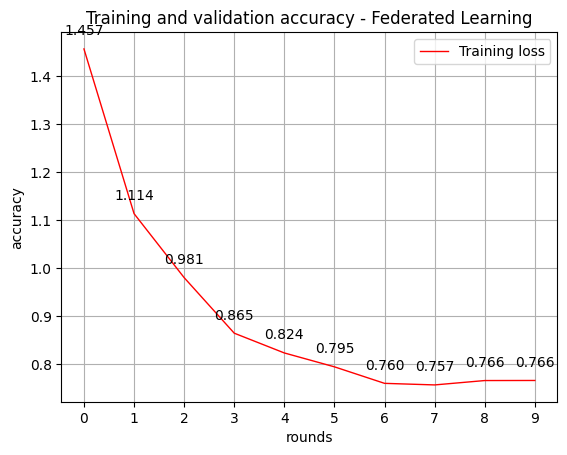

In [6]:
with open('./temp/FL_result.json','r') as json_data:
    result = json.load(json_data)
    acc = list(result['aggregated_accuracy'].values())
    loss = list(result['aggregated_loss'].values())


acc.remove(0)
loss.remove(0)
print(acc,loss)

rounds = range(len(acc))

plt.grid()
plt.plot(rounds, acc, 'b', label='Training accuracy')
# plt.plot(rounds, loss, 'r', linestyle='dashed', linewidth=1, label='Training loss')
plt.title('Training and validation accuracy - Federated Learning')
plt.xlabel('rounds')
plt.xticks(rounds)
plt.yticks(np.arange(0.5, 0.8, step=0.05))
for x,y in zip(rounds,acc):
    label = "{:.3f}".format(y)
    plt.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center')
    
plt.ylabel('accuracy')
plt.legend(loc=5)
plt.show()

plt.grid()
# plt.plot(rounds, acc, 'b', label='Training accuracy')
plt.plot(rounds, loss, 'r', linewidth=1, label='Training loss')
plt.title('Training and validation accuracy - Federated Learning')
plt.xlabel('rounds')
plt.xticks(rounds)
plt.ylabel('accuracy')
plt.legend(loc=0)
for x,y in zip(rounds,loss):
    label = "{:.3f}".format(y)
    plt.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center')
plt.show()

## Plot ROC AUC curve 

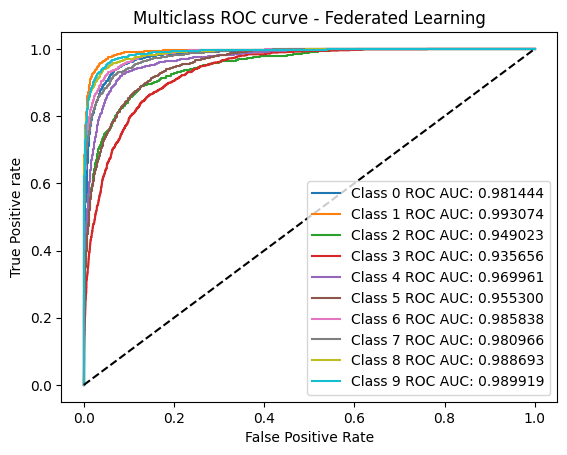

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


n_class = 10
fpr = {}
tpr = {}
thresh ={}
roc_aucs = []

y_true=[]

for i in range(n_class):
    y_true.append(y_test==i)    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, predictions[:,i], pos_label=i)
    roc_aucs.append(roc_auc_score(y_true[i], predictions[:,i]))


for i in range(n_class):    
    plt.plot(fpr[i],tpr[i],label='Class {} ROC AUC: {:3f}'.format(i,roc_aucs[i]))
plt.plot([0,1],[0,1],'k--')
plt.title('Multiclass ROC curve - Federated Learning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.show()



## Plot PR curve

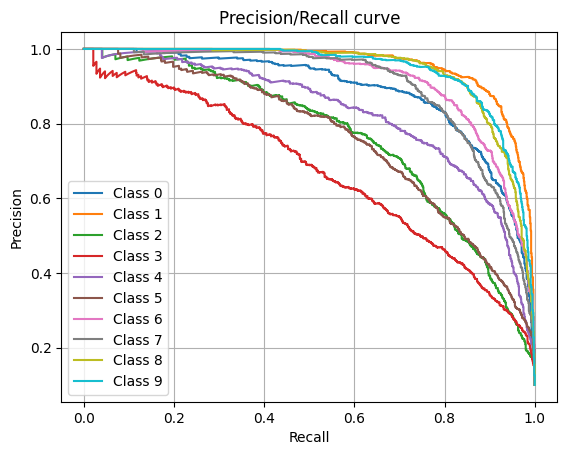

In [8]:
from sklearn.metrics import precision_recall_curve

n_class = 10
precision = {}
recall = {}
thresh ={}
y_true=[]

for i in range(n_class):
    y_true.append(y_test==i)    
    precision[i], recall[i], thresh[i] = precision_recall_curve(y_true[i], predictions[:,i])


for i in range(n_class):    
    plt.plot(recall[i],precision[i],label='Class {}'.format(i))
plt.grid()
plt.title('Precision/Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()  

## Classification report

In [9]:
from sklearn.metrics import classification_report

model_report = classification_report(
    y_true = y_test,
    y_pred = model_preds,
)

print(model_report)

              precision    recall  f1-score   support

           0       0.86      0.73      0.79      1000
           1       0.91      0.88      0.89      1000
           2       0.67      0.71      0.69      1000
           3       0.63      0.57      0.60      1000
           4       0.73      0.78      0.75      1000
           5       0.65      0.69      0.67      1000
           6       0.76      0.87      0.81      1000
           7       0.84      0.79      0.81      1000
           8       0.84      0.88      0.86      1000
           9       0.90      0.85      0.87      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

